In [136]:
# conda install pytorch torchvision torchaudio -c pytorch
# pip install transformers
# pip install nltk
# pip install numpy 
# pip install pandas
#pip install wordcloud
# conda install matplotlib
# pip install scholarly

In [133]:
import textract
from transformers import pipeline
import nltk
import numpy as np
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn

In [138]:
file_name = '2106.12139.pdf'
title = 'PatentNet: A Large-Scale Incomplete Multiview, Multimodal, Multilabel Industrial Goods Image Database'

{'container_type': 'Publication', 'source': <PublicationSource.PUBLICATION_SEARCH_SNIPPET: 1>, 'bib': {'title': 'PatentNet: A Large-Scale Incomplete Multiview, Multimodal, Multilabel Industrial Goods Image Database', 'author': ['F Lei', 'D Huang', 'J Jiang', 'R Ma', 'S Wang', 'J Cao'], 'pub_year': '2021', 'venue': 'arXiv preprint arXiv …', 'abstract': 'In deep learning area, large-scale image datasets bring a breakthrough in the success of object recognition and retrieval. Nowadays, as the embodiment of innovation, the diversity of the industrial goods is significantly larger, in which the incomplete multiview, multimodal and multilabel are different from the traditional dataset. In this paper, we introduce an industrial goods dataset, namely PatentNet, with numerous highly diverse, accurate and detailed annotations of industrial goods images, and corresponding texts. In PatentNet, the images'}, 'filled': False, 'gsrank': 1, 'pub_url': 'https://arxiv.org/abs/2106.12139', 'author_id': [

In [112]:

text = textract.process("refs/" + file_name).decode('utf-8')



In [113]:
import re

def gen_refs(text):
    regex = r'\[\d*\]\ ([A-Z]\.[^\[]*)\n'
    iterator = re.findall(regex, text)

    refs = []
    for match in iterator:
        refs.append(match) 

    # print(len(refs))
    return refs

In [141]:
refs = gen_refs(text)

In [126]:
nltk.download('stopwords')
full_stop_words = set(nltk.corpus.stopwords.words('english'))

full_stop_words.add('k')
full_stop_words.add('pp')

[nltk_data] Downloading package stopwords to /Users/liam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word)

def remove_set_from_dict(s, d):
    for t in s:
        if t in d:
            del d[t]
    return d
    
def word_frequencies(text):
    words = re.findall('[A-Za-z]+', text)
    frequencies = {}
    for w in words:
        w = w.lower()
        w = get_lemma(w)
        if w not in full_stop_words:
            if w in frequencies:
                frequencies[w] += 1
            else:
                frequencies[w] = 1
    return frequencies

In [130]:
freqs = word_frequencies(text)

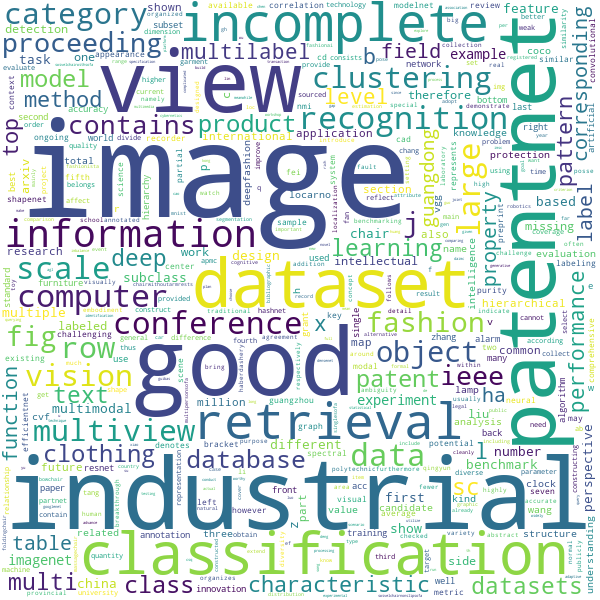

In [134]:
wordcloud = WordCloud(background_color="white", width=600, height=600, max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
#wordcloud.generate(long_string)
wordcloud.generate_from_frequencies(freqs)
wordcloud.to_file(f'data/word-cloud-{file_name}.png')
wordcloud.to_image()

In [234]:

def parse_ref(ref):
    segments = ref.split(',')
    authors = []
    title = ''
    journal = ''
    publisher = ''
    volume = ''
    year = ''
    pages = ''
    finished_authors = False
    author_count = 0
    for count, value in enumerate(segments):
        if value.find('.') > -1 and finished_authors == False:
            authors.append(value.strip())
            author_count = author_count + 1
        elif value.find('.') == -1 and count < author_count + 2:
            if finished_authors == False:
                finished_authors = True
                title = value
            else:
                journal = value
        elif count == len(segments) - 1 and author_count + 2 == len(segments) - 1:
            match = re.search(r'(.*)\((\d\d\d\d)\)(.*)', value)
            if match is not None:
                volume = match.groups()[0]
                year = match.groups()[1]
                pages = match.groups()[2]
        # For when year and pages are comma-separated
        elif count == len(segments) - 2 and author_count + 3 == len(segments) - 1:
            year = value
        elif count == len(segments) - 1 and author_count + 3 == len(segments) - 1:
            pages = value
        # For when volume / publisher, year and pages are comma-separated
        elif count == len(segments) - 3 and author_count + 4 == len(segments) - 1:
            if value.isdigit():
                volume = value
            else:
                publisher = value
        elif count == len(segments) - 2 and author_count + 4 == len(segments) - 1:
            year = value
        elif count == len(segments) - 1 and author_count + 4 == len(segments) - 1:
            pages = value
    return pd.DataFrame([[(', ').join(authors), title, journal, publisher, volume, year, pages, ref]], columns = ['authors', 'title', 'journal', 'publisher', 'volume', 'year', 'pages', 'full_ref'])


In [235]:
references = pd.DataFrame(columns = ['authors', 'title', 'journal', 'publisher', 'volume', 'year', 'pages', 'full_ref'])
for r in refs:
    r = r.replace('\n', ' ')
    references = references.append(parse_ref(r))

In [236]:
references

,authors,title,journal,publisher,volume,year,pages,full_ref
0,"Y. Guo, Y. Liu, A. Oerlemans, S. Lao, S. Wu, M...",Deep learning for visual understanding: A review,Neurocomputing,,187,2016,27-48.,"Y. Guo, Y. Liu, A. Oerlemans, S. Lao, S. Wu, M..."
0,"W. Rawat, Z. Wang",Deep convolutional neural networks for image ...,Neural computation,,29,2017,2352-2449.,"W. Rawat, Z. Wang, Deep convolutional neural n..."
0,"J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li, ...",Imagenet: A large-scale hierarchical image da...,2009 IEEE conference on computer vision and p...,Ieee,,2009,pp. 248-255.,"J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li, ..."
0,"T.-Y. Lin, M. Maire, S. Belongie, J. Hays, P. ...",Microsoft coco: Common objects in context,European conference on computer vision,Springer,,2014,pp. 740-755.,"T.-Y. Lin, M. Maire, S. Belongie, J. Hays, P. ..."
0,"Z. Liu, P. Luo, S. Qiu, X. Wang, X. Tang",Deepfashion: Powering robust clothes recognit...,Proceedings of the IEEE conference on compute...,,,2016,pp. 10961104.,"Z. Liu, P. Luo, S. Qiu, X. Wang, X. Tang, Deep..."
0,"Y. Ge, R. Zhang, X. Wang, X. Tang, P. Luo",Deepfashion2: A versatile benchmark for detec...,pose estimation,,,,,"Y. Ge, R. Zhang, X. Wang, X. Tang, P. Luo, Dee..."
0,"Z. Wu, S. Song, A. Khosla, F. Yu, L. Zhang, X....",3d shapenets: A deep representation for volum...,Proceedings of the IEEE conference on compute...,,,2015,pp. 1912-1920.,"Z. Wu, S. Song, A. Khosla, F. Yu, L. Zhang, X...."
0,"A.X. Chang, T. Funkhouser, L. Guibas, P. Hanra...",Shapenet: An information-rich 3d model reposi...,,,,2015,.,"A.X. Chang, T. Funkhouser, L. Guibas, P. Hanra..."
0,"M. Aubry, D. Maturana, A.A. Efros, B.C. Russel...",Seeing 3d chairs: exemplar part-based 2d-3d a...,Proceedings of the IEEE conference on compute...,,,2014,pp. 3762-3769.,"M. Aubry, D. Maturana, A.A. Efros, B.C. Russel..."
0,"B. de Bruijn, T.A. Nguyen, D. Bucur, K. Tei",Benchmark Datasets for Fault Detection and Cl...,SENSORNETS,,,2016,pp. 185-195.,"B. de Bruijn, T.A. Nguyen, D. Bucur, K. Tei, B..."


In [237]:

from scholarly import scholarly
for t in references['title']:
    print(next(scholarly.search_pubs(t)))


{'container_type': 'Publication', 'source': <PublicationSource.PUBLICATION_SEARCH_SNIPPET: 1>, 'bib': {'title': 'Deep learning for visual understanding: A review', 'author': ['Y Guo', 'Y Liu', 'A Oerlemans', 'S Lao', 'S Wu', 'MS Lew'], 'pub_year': '2016', 'venue': 'Neurocomputing', 'abstract': 'Deep learning algorithms are a subset of the machine learning algorithms, which aim at discovering multiple levels of distributed representations. Recently, numerous deep learning algorithms have been proposed to solve traditional artificial intelligence problems. This work aims to review the state-of-the-art in deep learning algorithms in computer vision by highlighting the contributions and challenges from over 210 recent research papers. It first gives an overview of various deep learning approaches and their recent developments, and'}, 'filled': False, 'gsrank': 1, 'pub_url': 'https://www.sciencedirect.com/science/article/pii/S0925231215017634', 'author_id': ['jksxCf8AAAAJ', 'gwdPLZUAAAAJ', 

MaxTriesExceededException: Cannot Fetch from Google Scholar.